# Tests for spatial filtering for NATL60

__purpose__ : optimize filtering for NATL60 using xarray and dask

In [2]:
## magics

%load_ext version_information 
%version_information numpy,xarray, dask


The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 2.7.11 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.2.0
OS Linux 3.16.0 4 amd64 x86_64 with debian 8.5
numpy 1.11.1
xarray 0.9.1
dask 0.10.0
Fri Feb 24 14:33:53 2017 CET

In [3]:
## path for mdules

import sys
sys.path.insert(0,"/home/albert/lib/python")

In [4]:
## imports

import numpy as np
import dask
import xarray as xr
import GriddedData
import time

#- Other modules
import os
from glob import glob
import numpy.ma as ma
import scipy as sc
import WavenumberSpectrum as ws
import dask.array as da

### palette
from matplotlib.colors import LogNorm
import matplotlib.cm as mplcm
import colormap as cmaps
import matplotlib.cm as cm

import seaborn as sns

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

## local/specific imports
import oocgcm
import oocgcm.filtering
import oocgcm.filtering.linearfilters as tf
%matplotlib inline

## 1. The size of the chunks in xarray

My computer has 32 Go DDR4 

1 2D field of NATL60 is 72Mo, 1 month of 2D fiels is 2.15Go

xarray documentation : "A good rule of thumb to create arrays with a minimum chunksize of at least one million elements (e.g., a 1000x1000 matrix). With large arrays (10+ GB), the cost of queueing up dask operations can be noticeable, and you may need even larger chunksizes."

NATL60 is 5422 x 3454

In [5]:
dir="/media/extra/DATA/NATL60/NATL60-CJM165-S/"
files03="NATL60-CJM165_y2013m03d*.1d_curloverf.nc"
files09="NATL60-CJM165_y2013m09d*.1d_curloverf.nc"

tfiles03=dir+files03
tfiles09=dir+files09


In [9]:
curls = xr.open_mfdataset(tfiles03,concat_dim='time_counter')['socurloverf'].chunk(chunks={'x': 1000, 'y':1000, 'time_counter': 1})
%timeit curls.sum()

100 loops, best of 3: 7.41 ms per loop


In [10]:
curlsbis = xr.open_mfdataset(tfiles03,concat_dim='time_counter')['socurloverf']
%timeit curlsbis.sum()

1000 loops, best of 3: 1.4 ms per loop


It looks like the no-chunk calculation took 1400ms whereas the 1M points chunk calculation took 741 ms (half)

In [11]:
from dask.diagnostics import ProgressBar

In [13]:
curls = xr.open_mfdataset(tfiles03,concat_dim='time_counter')['socurloverf'].chunk(chunks={'x': 1000, 'y':1000, 'time_counter': 1})
res=curls.sum()
with ProgressBar():
    out = res.compute()

[########################################] | 100% Completed |  5min 47.8s


In [14]:
curls = xr.open_mfdataset(tfiles03,concat_dim='time_counter')['socurloverf']
res=curls.sum()
with ProgressBar():
    out = res.compute()

[########################################] | 100% Completed | 14.5s


It looks like the no-chunk calculation took is quicker than the 1M points chunk calculation !!

In [15]:
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
curls = xr.open_mfdataset(tfiles03,concat_dim='time_counter')['socurloverf'].chunk(chunks={'x': 1000, 'y':1000, 'time_counter': 1})
res=curls.sum()
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    out = res.compute()

In [16]:
prof.results[0]

TaskData(key=('nansum-788f55a90437b17978073db771aa419b', 12, 2, 0), task=(<functools.partial object at 0x7f81a7bc8ba8>, (<function concatenate3 at 0x7f81ec6cb398>, [[[(<built-in function getitem>, (<function getarray at 0x7f81ec727c80>, CopyOnWriteArray(array=LazilyIndexedArray(array=MaskedAndScaledArray(LazilyIndexedArray(array=NetCDF4ArrayWrapper(array=<type 'netCDF4._netCDF4.Variable'>
float32 socurloverf(time_counter, y, x)
    units: -
    _FillValue: 0.0
    valid_min: -1000.0
    valid_max: 1000.0
    long_name: Relative_Vorticity (curl)
    short_name: socurl
    iweight: 1
    online_operation: N/A
    axis: TYX
    scale_factor: 1.0
    add_offset: 0.0
    savelog10: 0.0
unlimited dimensions: time_counter
current shape = (1, 3454, 5422)
filling on), key=(slice(None, None, None), slice(None, None, None), slice(None, None, None))), fill_value=array(0.0, dtype=float32), scale_factor=1.0, add_offset=0.0, dtype=<type 'float'>), key=(slice(None, None, None), slice(None, None, None)

In [17]:
rprof.results[0]

ResourceData(time=1487758110.368293, mem=1163.91936, cpu=0.0)

In [18]:
cprof.results[0]

CacheData(key=('nansum-788f55a90437b17978073db771aa419b', 0, 1, 2), task=(<functools.partial object at 0x7f81a7bc8ba8>, (<function concatenate3 at 0x7f81ec6cb398>, [[[(<built-in function getitem>, (<function getarray at 0x7f81ec727c80>, CopyOnWriteArray(array=LazilyIndexedArray(array=MaskedAndScaledArray(LazilyIndexedArray(array=NetCDF4ArrayWrapper(array=<type 'netCDF4._netCDF4.Variable'>
float32 socurloverf(time_counter, y, x)
    units: -
    _FillValue: 0.0
    valid_min: -1000.0
    valid_max: 1000.0
    long_name: Relative_Vorticity (curl)
    short_name: socurl
    iweight: 1
    online_operation: N/A
    axis: TYX
    scale_factor: 1.0
    add_offset: 0.0
    savelog10: 0.0
unlimited dimensions: time_counter
current shape = (1, 3454, 5422)
filling on), key=(slice(None, None, None), slice(None, None, None), slice(None, None, None))), fill_value=array(0.0, dtype=float32), scale_factor=1.0, add_offset=0.0, dtype=<type 'float'>), key=(slice(None, None, None), slice(None, None, None)

In [19]:
prof.visualize()

In [20]:
from dask.diagnostics import visualize

In [21]:
visualize([prof, rprof, cprof])

<img width="600" src="chunk1M1.png"></img>
<img width="600" src="chunk1M2.png"></img>
<img width="600" src="chunk1M3.png"></img>

In [22]:
curls = xr.open_mfdataset(tfiles03,concat_dim='time_counter')['socurloverf']
res=curls.sum()
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    out = res.compute()

Process _Tracker-2:
  File "/home/albert/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
  File "/home/albert/anaconda2/lib/python2.7/site-packages/dask/diagnostics/profile.py", line 216, in run
    ps = self._update_pids(pid)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/psutil/__init__.py", line 622, in status
  File "/home/albert/anaconda2/lib/python2.7/site-packages/dask/diagnostics/profile.py", line 212, in _update_pids
    if p.pid != pid and p.status() != 'zombie']
    return self._proc.status()
  File "/home/albert/anaconda2/lib/python2.7/site-packages/psutil/_pslinux.py", line 968, in wrapper
    raise NoSuchProcess(self.pid, self._name)
NoSuchProcess: psutil.NoSuchProcess process no longer exists (pid=19259)


In [23]:
prof.results[0]

TaskData(key=('nansum-0b1cf304078d734d2571ea90a92ba5fe', 16, 0, 0), task=(<functools.partial object at 0x7f81a6b35af8>, (<function getarray at 0x7f81ec727c80>, CopyOnWriteArray(array=LazilyIndexedArray(array=MaskedAndScaledArray(LazilyIndexedArray(array=NetCDF4ArrayWrapper(array=<type 'netCDF4._netCDF4.Variable'>
float32 socurloverf(time_counter, y, x)
    units: -
    _FillValue: 0.0
    valid_min: -1000.0
    valid_max: 1000.0
    long_name: Relative_Vorticity (curl)
    short_name: socurl
    iweight: 1
    online_operation: N/A
    axis: TYX
    scale_factor: 1.0
    add_offset: 0.0
    savelog10: 0.0
unlimited dimensions: time_counter
current shape = (1, 3454, 5422)
filling on), key=(slice(None, None, None), slice(None, None, None), slice(None, None, None))), fill_value=array(0.0, dtype=float32), scale_factor=1.0, add_offset=0.0, dtype=<type 'float'>), key=(slice(None, None, None), slice(None, None, None), slice(None, None, None)))), (slice(0, 1, None), slice(0, 3454, None), slice

In [24]:
rprof.results[0]

IndexError: list index out of range

In [25]:
cprof.results[0]

CacheData(key=('nansum-0b1cf304078d734d2571ea90a92ba5fe', 7, 0, 0), task=(<functools.partial object at 0x7f81a6b35af8>, (<function getarray at 0x7f81ec727c80>, CopyOnWriteArray(array=LazilyIndexedArray(array=MaskedAndScaledArray(LazilyIndexedArray(array=NetCDF4ArrayWrapper(array=<type 'netCDF4._netCDF4.Variable'>
float32 socurloverf(time_counter, y, x)
    units: -
    _FillValue: 0.0
    valid_min: -1000.0
    valid_max: 1000.0
    long_name: Relative_Vorticity (curl)
    short_name: socurl
    iweight: 1
    online_operation: N/A
    axis: TYX
    scale_factor: 1.0
    add_offset: 0.0
    savelog10: 0.0
unlimited dimensions: time_counter
current shape = (1, 3454, 5422)
filling on), key=(slice(None, None, None), slice(None, None, None), slice(None, None, None))), fill_value=array(0.0, dtype=float32), scale_factor=1.0, add_offset=0.0, dtype=<type 'float'>), key=(slice(None, None, None), slice(None, None, None), slice(None, None, None)))), (slice(0, 1, None), slice(0, 3454, None), slice

In [26]:
prof.visualize()

In [27]:
visualize([prof, rprof, cprof])

<img width="600" src="nochunk1.png"></img>
<img width="600" src="nochunk2.png"></img>
<img width="600" src="nochunk3.png"></img>

For the sum operation it looks like it is more efficient to compute without chunks

## Test of 2D spatial filtering on 1 time_step

In [4]:
curls = xr.open_mfdataset(tfiles03,concat_dim='time_counter')['socurloverf'].chunk(chunks={'x': 1000, 'y':1000, 'time_counter': 1})
curl0=curls[0]

In [5]:
win_box2D = curl0.win


In [6]:
win_box2D.set(window_name='lanczos', n=[120, 120], dims=['x', 'y'], fc=0.00833)


/home/albert/lib/python/oocgcm/filtering/linearfilters.py:58: RuntimeWarning: invalid value encountered in divide
  np.sin(np.pi * k / (n / 2.)) / (np.pi * k / (n / 2.)))


In [32]:
%timeit bw = win_box2D.boundary_weights(drop_dims=[])

1 loop, best of 3: 16min 46s per loop


In [7]:
%time bw = win_box2D.boundary_weights(drop_dims=[])

CPU times: user 16min 51s, sys: 7.16 s, total: 16min 59s
Wall time: 16min 58s


In [33]:
curls = xr.open_mfdataset(tfiles03,concat_dim='time_counter')['socurloverf']
curl0=curls[0]
win_box2D = curl0.win
win_box2D.set(window_name='lanczos', n=[120, 120], dims=['x', 'y'], fc=0.00833)

In [34]:
%timeit bw = win_box2D.boundary_weights(drop_dims=[])

1 loop, best of 3: 16min 35s per loop


In [35]:
%time bw = win_box2D.boundary_weights(drop_dims=[])

CPU times: user 16min 29s, sys: 5.87 s, total: 16min 35s
Wall time: 16min 34s


No gain with chunks, try with 2 time-steps

In [45]:
curls = xr.open_mfdataset(tfiles03,concat_dim='time_counter')['socurloverf'].chunk(chunks={'x': 1000, 'y':1000, 'time_counter': 1})
curl0=curls[0:2]
win_box2D = curl0.win
win_box2D.set(window_name='lanczos', n=[120, 120], dims=['x', 'y'], fc=0.00833)

In [46]:
%time bw = win_box2D.boundary_weights(drop_dims=[])

CPU times: user 32min 55s, sys: 10.5 s, total: 33min 5s
Wall time: 33min 4s


I have the impression that the chunking in time does not gain on performance for this calculation

Computer boundary weights for all month

In [7]:
curl = xr.open_mfdataset(tfiles03,concat_dim='time_counter')['socurloverf'].chunk(chunks={'x': 1000, 'y':1000, 'time_counter': 1})
win_box2D = curl.win
win_box2D.set(window_name='lanczos', n=[120, 120], dims=['x', 'y'], fc=0.00833)

/home/albert/lib/python/oocgcm/filtering/linearfilters.py:58: RuntimeWarning: invalid value encountered in divide
  np.sin(np.pi * k / (n / 2.)) / (np.pi * k / (n / 2.)))


In [8]:
%time bw = win_box2D.boundary_weights(drop_dims=[])

CPU times: user 8h 22min 54s, sys: 1min 26s, total: 8h 24min 20s
Wall time: 8h 29min 36s


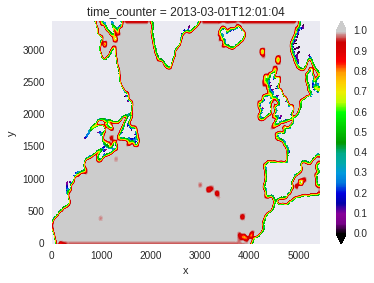

In [10]:
bw.plot(vmin=0, vmax=1, cmap='spectral')

In [11]:
signal_LS = win_box2D.apply(weights=bw)

[##########                              ] | 27% Completed | 46.0s


MemoryError: 

Traceback
---------
  File "/home/albert/anaconda2/lib/python2.7/site-packages/dask/async.py", line 267, in execute_task
    result = _execute_task(task, data)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/dask/async.py", line 248, in _execute_task
    args2 = [_execute_task(a, cache) for a in args]
  File "/home/albert/anaconda2/lib/python2.7/site-packages/dask/async.py", line 249, in _execute_task
    return func(*args2)
  File "/home/albert/lib/python/oocgcm/filtering/linearfilters.py", line 202, in convolve
    xf = im.convolve(x, self.coefficients, mode=mode)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/scipy/ndimage/filters.py", line 755, in convolve
    origin, True)
  File "/home/albert/anaconda2/lib/python2.7/site-packages/scipy/ndimage/filters.py", line 603, in _correlate_or_convolve
    _nd_image.correlate(input, weights, output, mode, cval, origins)
